In [ ]:
# install dependencies
!pip uninstall tensorflow \
  tensorflow-gpu
!pip install keras==2.0.8 \
  tensorflow-gpu==1.14.0 \
  scikit-image==0.14.2 \
  imgaug==0.2.5

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 276kB 5.5MB/s 
     |████████████████████████████████| 377.1MB 46kB/s 
     |████████████████████████████████| 25.3MB 127kB/s 
     |████████████████████████████████| 563kB 37.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 491kB 35.5MB/s 
     |████████████████████████████████| 3.2MB 37.0MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-cp37-none-any.whl size=561439 sha256=ff7f435

In [ ]:
# setup depth network - adabins and load model

%cd /content/drive/MyDrive/AdaBins

import glob
import os

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

import model_io
import utils
from models import UnetAdaptiveBins


def _is_pil_image(img):
    return isinstance(img, Image.Image)


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


class ToTensor(object):
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __call__(self, image, target_size=(640, 480)):
        # image = image.resize(target_size)
        image = self.to_tensor(image)
        image = self.normalize(image)
        return image

    def to_tensor(self, pic):
        if not (_is_pil_image(pic) or _is_numpy_image(pic)):
            raise TypeError(
                'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

        if isinstance(pic, np.ndarray):
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            return img

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)

        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float()
        else:
            return img


class InferenceHelper:
    def __init__(self, dataset='nyu', device='cuda'):
        self.toTensor = ToTensor()
        self.device = device
        if dataset == 'nyu':
            self.min_depth = 1e-3
            self.max_depth = 10
            self.saving_factor = 1000  # used to save in 16 bit
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "./pretrained/AdaBins_nyu.pt"
        elif dataset == 'kitti':
            self.min_depth = 1e-3
            self.max_depth = 80
            self.saving_factor = 256
            model = UnetAdaptiveBins.build(n_bins=256, min_val=self.min_depth, max_val=self.max_depth)
            pretrained_path = "./pretrained/AdaBins_kitti.pt"
        else:
            raise ValueError("dataset can be either 'nyu' or 'kitti' but got {}".format(dataset))

        model, _, _ = model_io.load_checkpoint(pretrained_path, model)
        model.eval()
        self.model = model.to(self.device)

    @torch.no_grad()
    def predict_pil(self, pil_image, visualized=False):
        # pil_image = pil_image.resize((640, 480))
        img = np.asarray(pil_image) / 255.

        img = self.toTensor(img).unsqueeze(0).float().to(self.device)
        pred = self.predict(img)
        if visualized:
            viz = utils.colorize(torch.from_numpy(pred).unsqueeze(0), vmin=None, vmax=None, cmap='magma')
            # pred = np.asarray(pred*1000, dtype='uint16')
            viz = Image.fromarray(viz)
            return bin_centers, pred, viz
        return pred

    @torch.no_grad()
    def predict(self, image):
        bins, pred = self.model(image)
        pred = np.clip(pred.detach().cpu().numpy(), self.min_depth, self.max_depth)

        # Flip
        image = torch.Tensor(np.array(image.cpu().numpy())[..., ::-1].copy()).to(self.device)
        pred_lr = self.model(image)[-1]
        pred_lr = np.clip(pred_lr.detach().cpu().numpy()[..., ::-1], self.min_depth, self.max_depth)

        # Take average of original and mirror
        final = 0.5 * (pred + pred_lr)
        final = nn.functional.interpolate(torch.Tensor(final), image.shape[-2:],
                                          mode='bilinear', align_corners=True).cpu().numpy()

        final[final < self.min_depth] = self.min_depth
        final[final > self.max_depth] = self.max_depth
        final[np.isinf(final)] = self.max_depth
        final[np.isnan(final)] = self.min_depth

        # centers = 0.5 * (bins[:, 1:] + bins[:, :-1])
        # centers = centers.cpu().squeeze().numpy()
        # centers = centers[centers > self.min_depth]
        # centers = centers[centers < self.max_depth]

        return final

    @torch.no_grad()
    def predict_dir(self, test_dir, out_dir):
        os.makedirs(out_dir, exist_ok=True)
        transform = ToTensor()
        all_files = glob.glob(os.path.join(test_dir, "*"))
        self.model.eval()
        for f in tqdm(all_files):
            image = np.asarray(Image.open(f), dtype='float32') / 255.
            image = transform(image).unsqueeze(0).to(self.device)

            centers, final = self.predict(image)
            # final = final.squeeze().cpu().numpy()

            final = (final * self.saving_factor).astype('uint16')
            basename = os.path.basename(f).split('.')[0]
            save_path = os.path.join(out_dir, basename + ".png")

            Image.fromarray(final).save(save_path)


with torch.no_grad():
  inferHelper = InferenceHelper()

/content/drive/MyDrive/AdaBins
Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.


In [ ]:
# setup network maskrcnn

%cd /content/drive/MyDrive/Mask_RCNN/
!python setup.py install

/content/drive/MyDrive/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
adding license file 

In [ ]:
# load rcnn model 

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt

import os
import sys
import json
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Root directory of the project
ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

############################################################
#  Configurations
############################################################



# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_instances

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
logs= os.path.join(ROOT_DIR, "logs")

class BalloonConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "balloon"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


############################################################
#  Dataset
############################################################

class BalloonDataset(utils.Dataset):

    def load_balloon(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("balloon", 1, "balloon")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "balloon",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "balloon":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = BalloonDataset()
    dataset_train.load_balloon(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BalloonDataset()
    dataset_val.load_balloon(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')


def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image, video_path=None):
    r = model.detect([image], verbose=1)[0]
    return r
    

class InferenceConfig(BalloonConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

model = modellib.MaskRCNN(mode="inference", config=config, model_dir=logs)
weights_path = '/content/drive/MyDrive/Mask_RCNN/mask_rcnn_balloon.h5'
model.load_weights(weights_path, by_name=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# process for photogrametry

from math import radians, cos, sin
def get_rot(pry):
  a=radians(pry[2])
  b=radians(pry[0])
  g=radians(pry[1])
  r1=[cos(a)*cos(b), (cos(a)*sin(b)*sin(g))-(sin(a)*cos(g)), (cos(a)*sin(b)*cos(g))+(sin(a)*sin(g))]
  r2=[sin(a)*cos(b), (cos(a)*sin(b)*sin(g))+(cos(a)*cos(g)), (sin(a)*sin(b)*cos(g))-(cos(a)*sin(g))]
  r3=[0-sin(b), cos(b)*sin(g), cos(b)*cos(g)]
  return(np.asarray([r1, r2, r3]))                                                           

def mat(pry, tran):
  rot=get_rot(pry)
  conv=np.asarray([[-1,0,0],
                 [0,0,1],
                 [0,1,0]])
  tran=np.asarray([[1,0,0,-tran[0]],
                   [0,1,0,-tran[1]],
                   [0,0,1,-tran[2]]])
  return((rot@tran),conv)

In [ ]:
# read image for process

import cv2
import time
from PIL import Image
st=time.time()
img=cv2.imread("/content/drive/MyDrive/img_7.jpg")
with torch.no_grad():
  pred = inferHelper.predict_pil(img)
img=np.asarray(img)
r=detect_and_color_splash(model, img, video_path=None)
print(time.time()-st)

Processing 1 images
image                    shape: (640, 480, 3)         min:    4.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
11.622938394546509


In [ ]:
# img[:,:,0][r['masks'][:,:,0]==False]=0
# img[:,:,2][r['masks'][:,:,0]==False]=0
pred[0,0].shape

(640, 480)

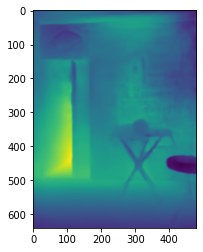

In [ ]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
plt.imshow(pred[0,0])

In [ ]:

# test for single image

intrin=np.asarray([[424.73486349, 0., 223.21701931],
                  [ 0., 438.5143282, 324.4098755 ],
                  [ 0.,   0., 1.]])
# rot=np.asarray([[1,0,0], [0,1,0], [0,0,1]])
# tran=[0,0,0]
extrininv,conv=mat([0,0,0],[0,0,0])
# extrin=np.asarray([[8.045017123222351074e-01, -2.037209272384643555e-01, 5.579200983047485352e-01, 5.043879098892212198e+00],
                  #  [-5.914024114608764648e-01, -1.878403425216674805e-01, 7.841933369636535645e-01, 4.060233421325683878e+00],
                  #  [-5.495670065283775330e-02, -9.608401656150817871e-01, -2.715989053249359131e-01, 2.012014386653900200e+00]])
# h=np.linalg.inv(np.concatenate((intrin@extrin,[[0,0,0,1]])))[:3]

if r['masks'].shape[-1] > 0:
  a=np.zeros(r['masks'][:,:,0].shape)
  a[r['masks'][:,:,0]]=255
  y,x=np.where(a==255)
  _=[1]*len(x)
  j=np.asarray([x,y,_])
  p=[pred.squeeze()[y,x]]*3
  p=np.asarray(p)
  c1=np.concatenate((conv@((np.linalg.inv(intrin)@j)*p),[_]))
  c2=np.concatenate((extrininv,[[0,0,0,1]]))
  c=c2@c1#(np.asarray([j[:,0]/26,j[:,1]/2.85,j[:,2]]).T@np.linalg.inv(intrin)-tran)@(np.linalg.inv(rot))
  ck=np.mean(c,1)
  i=np.mean(j,1).astype(np.int)[:2]
print(time.time()-st)

In [ ]:
# setup webcam stream

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      // const div = document.createElement('div');
      // const capture = document.createElement('button');
      // capture.textContent = 'Capture';
      // div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // document.body.appendChild(div);
      // div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      // div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  # faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  #cv2.imwrite(filename, img)

  return img

In [ ]:
# funcs to get stream

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img
  
from IPython.display import Image
import time
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
  
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

ReferenceError: capture is not defined


In [ ]:
#live test

video_stream()
import numpy as np
import cv2
# label for video
from PIL import Image

import asyncio
import random
import nest_asyncio
nest_asyncio.apply()


label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

async def depth(img): 
  st=time.time()
  pred = inferHelper.predict_pil(img) #depth
  print("depth: ",time.time()-st)
  return(pred)

async def ball(img):
  st=time.time()
  r = detect_and_color_splash(model, img, video_path=None) #rcnn
  print("ball: ", time.time()-st)
  return(r)

async def main(img):
    ## define a future object    
    st=time.time()
    task=[asyncio.ensure_future(ball(img)), asyncio.ensure_future(depth(img))]
    await asyncio.gather(*task)
    ## Print the result of our future
    print("main: ",time.time()-st)
    return(task[0].result(),task[1].result())
loop = asyncio.get_event_loop()

while True:
    st=time.time()
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
   
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    ac=time.time()
    print(ac-st)
    
 
    r, pred = loop.run_until_complete(main(img))
   
    
    intrin=np.asarray([[424.73486349, 0., 223.21701931],
                      [ 0., 438.5143282, 324.4098755 ],
                      [ 0.,   0., 1.]])
# rot=np.asarray([[1,0,0], [0,1,0], [0,0,1]])
# tran=[0,0,0]
    extrininv,conv=mat([0,0,0],[0,0,0])
# extrin=np.asarray([[8.045017123222351074e-01, -2.037209272384643555e-01, 5.579200983047485352e-01, 5.043879098892212198e+00],
                  #  [-5.914024114608764648e-01, -1.878403425216674805e-01, 7.841933369636535645e-01, 4.060233421325683878e+00],
                  #  [-5.495670065283775330e-02, -9.608401656150817871e-01, -2.715989053249359131e-01, 2.012014386653900200e+00]])
# h=np.linalg.inv(np.concatenate((intrin@extrin,[[0,0,0,1]])))[:3]

    if r['masks'].shape[-1] > 0:
      a=np.zeros(r['masks'][:,:,0].shape)
      a[r['masks'][:,:,0]]=255
      y,x=np.where(a==255)
      _=[1]*len(x)
      j=np.asarray([x,y,_])
      p=[pred.squeeze()[y,x]]*3
      p=np.asarray(p)
      c1=np.concatenate((conv@((np.linalg.inv(intrin)@j)*p),[_]))
      c2=np.concatenate((extrininv,[[0,0,0,1]]))
      c=c2@c1#(np.asarray([j[:,0]/26,j[:,1]/2.85,j[:,2]]).T@np.linalg.inv(intrin)-tran)@(np.linalg.inv(rot))
      ck=np.mean(c,1)
      i=np.mean(j,1).astype(np.int)[:2]
      print(time.time()-st, time.time()-ac, ck)
    else:
      print(time.time()-st, time.time()-ac, "skipped")

<IPython.core.display.Javascript object>

1.325387716293335
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
ball:  10.835702896118164
depth:  0.3789710998535156
main:  11.215567588806152
12.542030572891235 11.216643333435059 skipped
1.1117196083068848
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
ball:  0.3785209655761719
depth:  

KeyboardInterrupt: ignored

In [ ]:
import multiprocessing as mp
mp.cpu_count()

2

In [ ]:


async def myCoroutine1(future):
    ## simulate some 'work'
    print("started1")
    time.sleep(0.2)
    ## set the result of our future object
    return("My Coroutine-turned-future1 has completed")

async def myCoroutine2(future):
    ## simulate some 'work'
    print("started2")
    time.sleep(0.5)
    ## set the result of our future object
    return("My Coroutine-turned-future2 has completed")


async def main():
    ## define a future object
    st=time.time()
    future=asyncio.Future()
    task=[asyncio.ensure_future(myCoroutine1(future)), asyncio.ensure_future(myCoroutine2(future))]
    await asyncio.gather(*task)
    ## Print the result of our future
    print(time.time()-st)
    print(task[0].result(),task[1].result())
    #print(future.result())

## Spin up a quick and simple event loop
## and run until completed
loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(main())
finally:
    pass

started1
started2
0.7018990516662598
My Coroutine-turned-future1 has completed My Coroutine-turned-future2 has completed


In [ ]:
future=asyncio.Future()
myCoroutine1(future)
myCoroutine2(future)

AttributeError: ignored